In [1]:
import sys
sys.path.append("../../")

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from botorch.utils.sampling import draw_sobol_samples

from optimizers.lfbo.lfbo_rff import LFBO_RFF
from botorch.test_functions.multi_objective import BraninCurrin

tkwargs = {"device": "cpu:0", "dtype": torch.double}

In [3]:
problem = BraninCurrin()

In [4]:
num_dim = problem.bounds.shape[-1]
# only plot the first two dimensions
xx, yy = np.meshgrid(
    np.linspace(
        *problem.bounds.t()[0], 100
    ),
    np.linspace(
        *problem.bounds.t()[1], 100
    ),
)
input_dense = np.vstack((xx.flatten(), yy.flatten())).T
input_dense = torch.from_numpy(input_dense)
z = problem(input_dense)[:, :1]

num_obs = 64
x_obs = draw_sobol_samples(bounds=problem.bounds, n=num_obs, q=1, seed=123).squeeze(1)
y_obs = problem(x_obs)[:, :1]

In [6]:
lfbo = LFBO_RFF(input_dim=2)
lfbo.fit(x_obs, y_obs, S=100)

In [7]:
acf_mean, acf_samples = lfbo.predict(input_dense)
acf_probit = lfbo.probit_predict(input_dense)
acf_std = torch.std(acf_samples, axis=0)

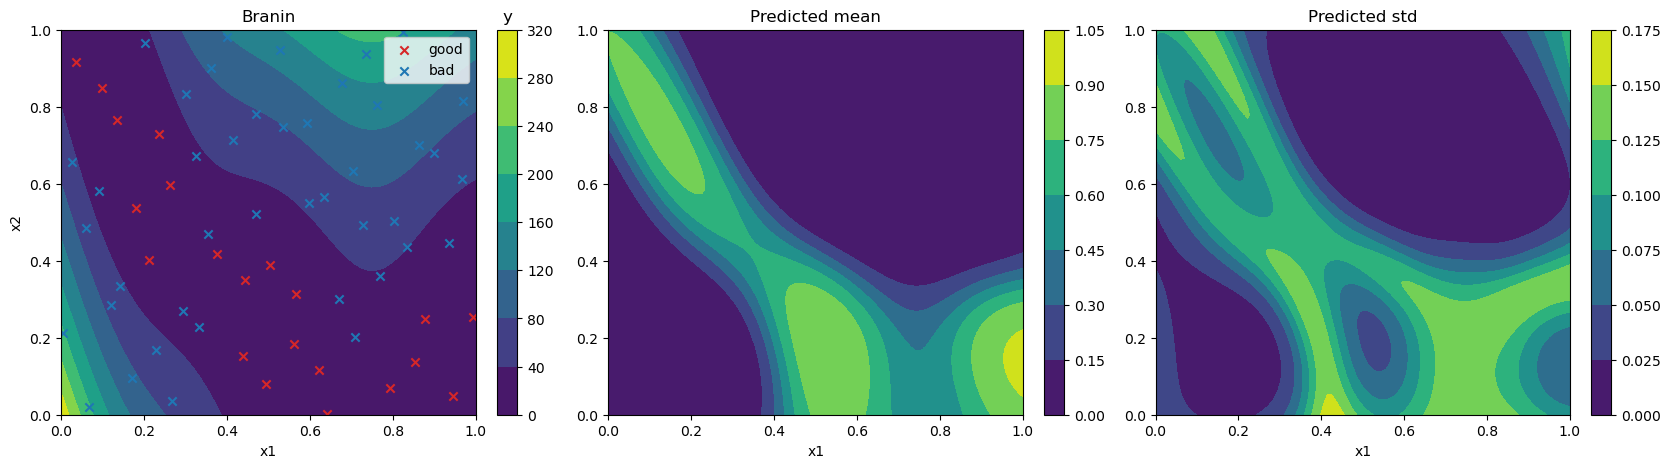

In [8]:
fig = plt.figure(figsize=(20, 5))

ax_func = plt.subplot2grid((1, 3), (0, 0), rowspan=1)
div = make_axes_locatable(ax_func)
cax = div.append_axes('right', '5%', '5%')

countourset = ax_func.contourf(
    xx,
    yy,
    z.reshape(xx.shape),
)
cax.grid(False)  # just to remove the warning
clb = fig.colorbar(countourset, cax=cax)

_, _, label, _ = lfbo.split_good_bad(x_obs, y_obs, gamma=1/3, acq_type='pi')
ax_func.scatter(*x_obs.t()[:, label.squeeze()], marker='x', color='tab:red', label="good")
ax_func.scatter(*x_obs.t()[:, ~label.squeeze()], marker='x', color='tab:blue', label="bad")

ax_func.set_xlabel('x1')
ax_func.set_ylabel('x2')
ax_func.set_title(f"Branin")
clb.ax.set_title('y')
ax_func.set_xlim(problem.bounds[0, 0], problem.bounds[1, 0])
ax_func.legend()

ax_lfbo = plt.subplot2grid((1, 3), (0, 1), rowspan=1, sharex=ax_func)
div = make_axes_locatable(ax_lfbo)
cax = div.append_axes('right', '5%', '5%')
countourset = ax_lfbo.contourf(
    xx,
    yy,
    acf_mean.reshape(xx.shape),
)
cax.grid(False)  # just to remove the warning
clb = fig.colorbar(countourset, cax=cax)
ax_lfbo.set_xlabel('x1')
ax_lfbo.set_title(f"Predicted mean")

ax_var = plt.subplot2grid((1, 3), (0, 2), rowspan=1, sharex=ax_func)
div = make_axes_locatable(ax_var)
cax = div.append_axes('right', '5%', '5%')
countourset = ax_var.contourf(
    xx,
    yy,
    acf_std.reshape(xx.shape),
)
cax.grid(False)  # just to remove the warning
clb = fig.colorbar(countourset, cax=cax)
ax_var.set_xlabel('x1')
ax_var.set_title(f"Predicted std");

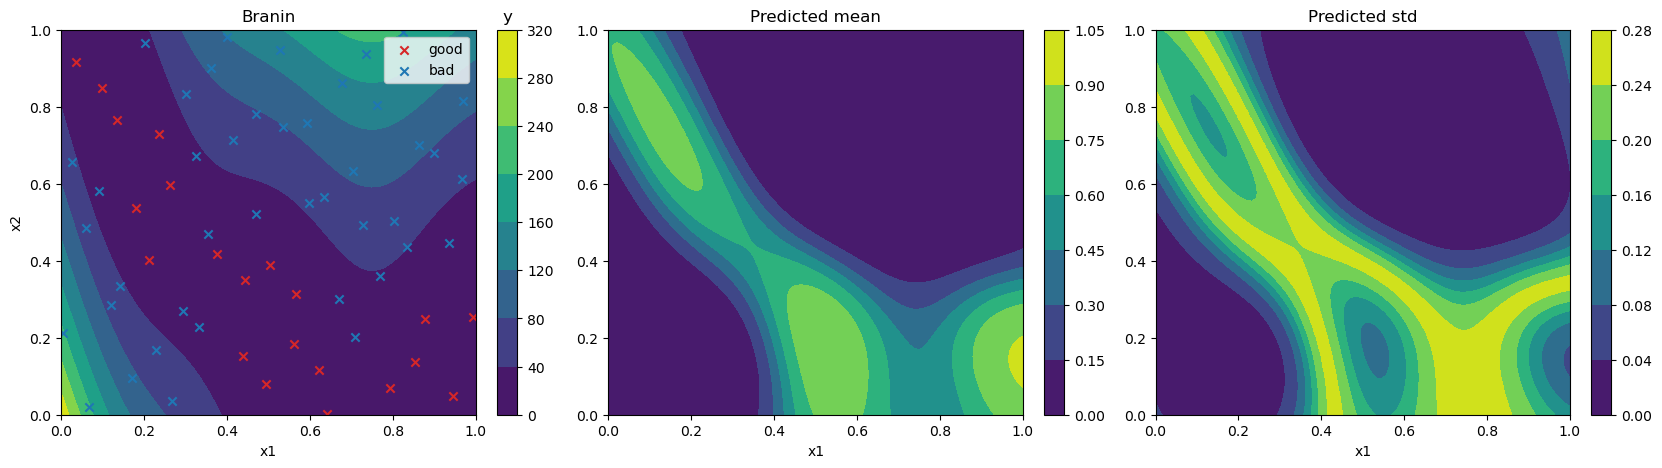

In [9]:
fig = plt.figure(figsize=(20, 5))

ax_func = plt.subplot2grid((1, 3), (0, 0), rowspan=1)
div = make_axes_locatable(ax_func)
cax = div.append_axes('right', '5%', '5%')

countourset = ax_func.contourf(
    xx,
    yy,
    z.reshape(xx.shape),
)
cax.grid(False)  # just to remove the warning
clb = fig.colorbar(countourset, cax=cax)

_, _, label, _ = lfbo.split_good_bad(x_obs, y_obs, gamma=1/3, acq_type='pi')
ax_func.scatter(*x_obs.t()[:, label.squeeze()], marker='x', color='tab:red', label="good")
ax_func.scatter(*x_obs.t()[:, ~label.squeeze()], marker='x', color='tab:blue', label="bad")

ax_func.set_xlabel('x1')
ax_func.set_ylabel('x2')
ax_func.set_title(f"Branin")
clb.ax.set_title('y')
ax_func.set_xlim(problem.bounds[0, 0], problem.bounds[1, 0])
ax_func.legend()

ax_lfbo = plt.subplot2grid((1, 3), (0, 1), rowspan=1, sharex=ax_func)
div = make_axes_locatable(ax_lfbo)
cax = div.append_axes('right', '5%', '5%')
countourset = ax_lfbo.contourf(
    xx,
    yy,
    acf_probit.reshape(xx.shape),
)
cax.grid(False)  # just to remove the warning
clb = fig.colorbar(countourset, cax=cax)
ax_lfbo.set_xlabel('x1')
ax_lfbo.set_title(f"Predicted mean")

ax_var = plt.subplot2grid((1, 3), (0, 2), rowspan=1, sharex=ax_func)
div = make_axes_locatable(ax_var)
cax = div.append_axes('right', '5%', '5%')
countourset = ax_var.contourf(
    xx,
    yy,
    (acf_probit * (1 - acf_probit)).reshape(xx.shape),
)
cax.grid(False)  # just to remove the warning
clb = fig.colorbar(countourset, cax=cax)
ax_var.set_xlabel('x1')
ax_var.set_title(f"Predicted std");